In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Comparison of Bayesian Optimization Frameworks

In [2]:
RANDOM_SEED = 42

## :eyes: General Insights

In [3]:
df = pd.read_csv('../datasets/student-alcohol-consumption.csv', index_col=[0])
print(df.shape)
df.head(5)

(395, 29)


,school,sex,age,famsize,Pstatus,Medu,Fedu,traveltime,failures,schoolsup,...,goout,Dalc,Walc,health,absences,G1,G2,G3,location,study_time
0,GP,F,18,GT3,A,4,4,2,0,yes,...,4,1,1,3,6,5,6,6,Urban,2 to 5 hours
1,GP,F,17,GT3,T,1,1,1,0,no,...,3,1,1,3,4,5,5,6,Urban,2 to 5 hours
2,GP,F,15,LE3,T,1,1,1,3,yes,...,2,2,3,3,10,7,8,10,Urban,2 to 5 hours
3,GP,F,15,GT3,T,4,2,1,0,no,...,2,1,1,5,2,15,14,15,Urban,5 to 10 hours
4,GP,F,16,GT3,T,3,3,1,0,no,...,2,1,2,5,4,6,10,10,Urban,2 to 5 hours


In [4]:
df.dtypes

school        object
sex           object
age            int64
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
traveltime     int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
location      object
study_time    object
dtype: object

According to the [Kaggle description](https://www.kaggle.com/datasets/uciml/student-alcohol-consumption) the columns are defined as follows:

| Column     | Description                                                                                      |
|------------|--------------------------------------------------------------------------------------------------|
| school     | student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)                |
| sex        | student's sex (binary: 'F' - female or 'M' - male)                                            |
| age        | student's age (numeric: from 15 to 22)                                                        |
| address    | student's home address type (binary: 'U' - urban or 'R' - rural)                             |
| famsize    | family size (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)                   |
| Pstatus    | parent's cohabitation status (binary: 'T' - living together or 'A' - apart)                   |
| Medu       | mother's education (numeric: 0 - none, 1 - primary education (4th grade), ...)                |
| Fedu       | father's education (numeric: 0 - none, 1 - primary education (4th grade), ...)                |
| Mjob       | mother's job (nominal: 'teacher', 'health' care related, ...)                                  |
| Fjob       | father's job (nominal: 'teacher', 'health' care related, ...)                                  |
| reason     | reason to choose this school (nominal: close to 'home', school 'reputation', ...)               |
| guardian   | student's guardian (nominal: 'mother', 'father' or 'other')                                    |
| traveltime | home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., ...)                     |
| studytime  | weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, ...)                                |
| failures   | number of past class failures (numeric: n if 1<=n<3, else 4)                                   |
| schoolsup  | extra educational support (binary: yes or no)                                                   |
| famsup     | family educational support (binary: yes or no)                                                   |
| paid       | extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)           |
| activities | extra-curricular activities (binary: yes or no)                                                 |
| nursery    | attended nursery school (binary: yes or no)                                                     |
| higher     | wants to take higher education (binary: yes or no)                                              |
| internet   | Internet access at home (binary: yes or no)                                                     |
| romantic   | with a romantic relationship (binary: yes or no)                                                |
| famrel     | quality of family relationships (numeric: from 1 - very bad to 5 - excellent)                    |
| freetime   | free time after school (numeric: from 1 - very low to 5 - very high)                             |
| goout      | going out with friends (numeric: from 1 - very low to 5 - very high)                             |
| Dalc       | workday alcohol consumption (numeric: from 1 - very low to 5 - very high)                         |
| Walc       | weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)                         |
| health     | current health status (numeric: from 1 - very bad to 5 - very good)                               |
| absences   | number of school absences (numeric: from 0 to 93)                                               |
| G1         | first period grade (numeric: from 0 to 20)                                                       |
| G2         | second period grade (numeric: from 0 to 20)                                                      |
| G3         | final grade (numeric: from 0 to 20, output target)                                               |


> The objective could be to **predict the students final grade** (`G3`).

In [5]:
value_counts = df['G3'].value_counts().sort_index()
total_count = value_counts.sum()
percentage = round((value_counts / total_count) * 100, 2)
result_df = pd.DataFrame({
    'Count': value_counts,
    'Percentage': percentage
}).reset_index().rename(columns={'index': 'G3'})

result_df

,G3,Count,Percentage
0,0,38,9.62
1,4,1,0.25
2,5,7,1.77
3,6,15,3.80
4,7,9,2.28
5,8,32,8.10
6,9,28,7.09
7,10,56,14.18
8,11,47,11.90
9,12,31,7.85


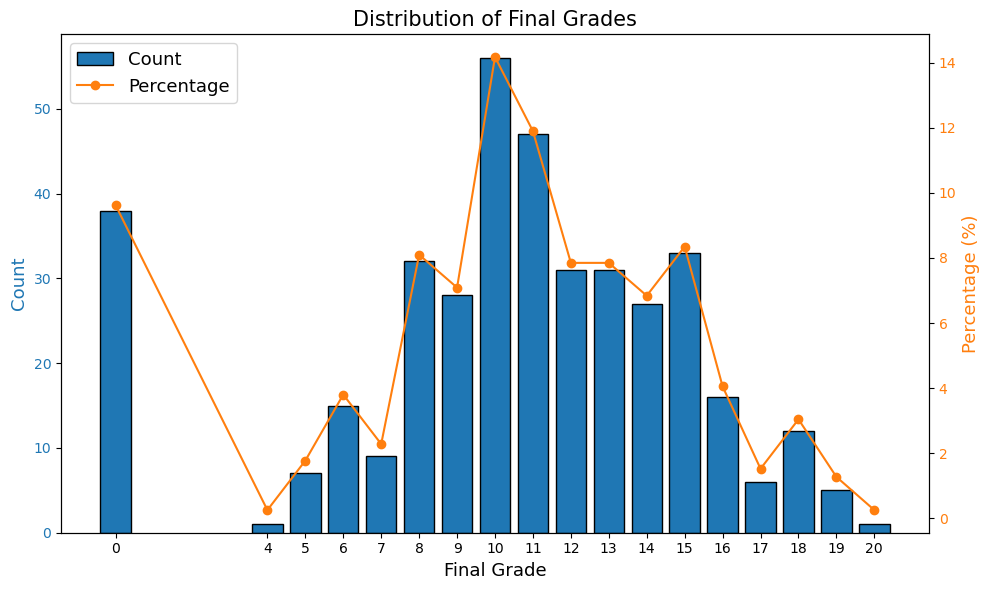

In [6]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the count on the left y-axis
ax1.bar(result_df.G3, result_df['Count'], edgecolor='black', color='C0', label='Count')
ax1.set_xlabel('Final Grade', fontsize=13)
ax1.set_ylabel('Count', color='C0', fontsize=13)
ax1.tick_params(axis='y', labelcolor='C0')

# Create a twin y-axis for the percentage
ax2 = ax1.twinx()
ax2.plot(result_df.G3, result_df['Percentage'], color='C1', marker='o', label='Percentage')
ax2.set_ylabel('Percentage (%)', color='C1', fontsize=13)
ax2.tick_params(axis='y', labelcolor='C1')

# Combine the legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, fontsize=13, loc='upper left')

plt.title('Distribution of Final Grades', fontsize=15)
plt.xticks(result_df.G3)
plt.tight_layout()

plt.show()

## EDA on Features 

Now let's investigate the features we are going to use to predict the target `G3` (final grade).

In [9]:
df_feat = df.loc[:, ~df.columns.isin(['G1', 'G2', 'G3'])]
print(df_feat.shape)
df.dtypes

(395, 26)


school        object
sex           object
age            int64
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
traveltime     int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G1             int64
G2             int64
G3             int64
location      object
study_time    object
dtype: object

We have 26 features which can be used as predictors.

### `int` Columns

In [51]:
int_columns = df_feat.select_dtypes(include=['int']).columns
print(f"There are {len(int_columns)} ({100*len(int_columns)/df_feat.shape[1]:2.2f}%) columns of type int.")
int_columns = int_columns.tolist()
int_columns

There are 12 (46.15%) columns of type int.


['age',
 'Medu',
 'Fedu',
 'traveltime',
 'failures',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences']

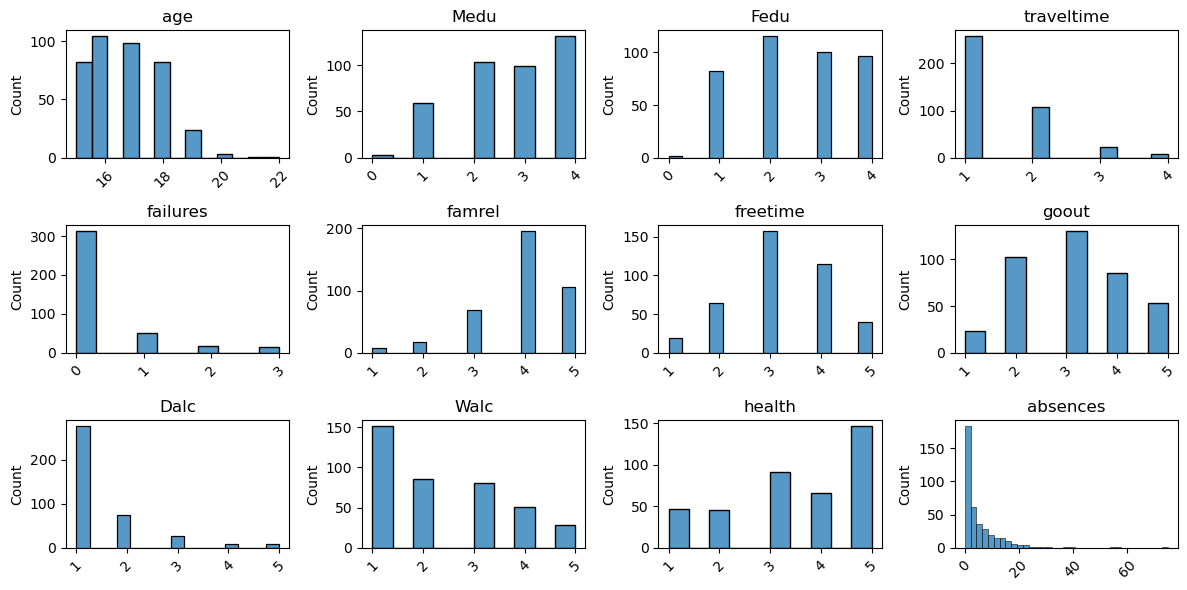

In [73]:
num_cols = 4
num_rows = (len(int_columns) - 1) // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5)

for i, int_col in enumerate(int_columns):
    row = i // num_cols
    col = i % num_cols
    row, col = np.unravel_index(i, (num_rows, num_cols))
    ax = axes[row, col]
    
    sns.histplot(df_feat[int_col], ax=ax)
    ax.set_title(int_col)
    ax.set_xlabel('')
    
    ax.tick_params(axis='x', labelrotation=45)

for i in range(len(int_columns), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])
    plt.show() 

plt.tight_layout()
plt.show()    

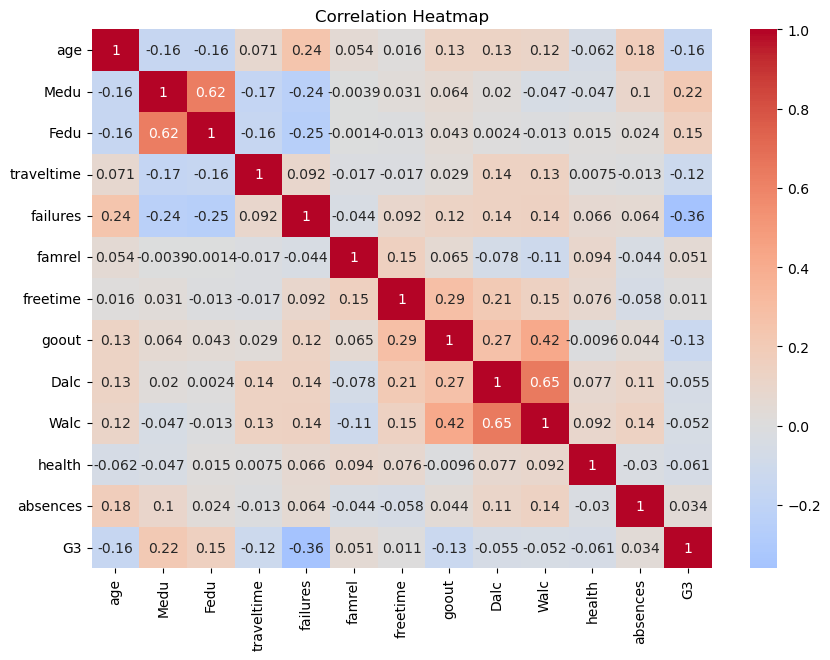

In [69]:
corr_mat = df[int_columns + ['G3']].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()